In [ ]:
import numpy as np
import multiprocessing as mp
import time

# Problem parameters
N_NODES = 10
N_SOURCES = 3
T_SLOTS = 24

# Cost per source (random example)
C = np.array([10, 5, 3])

# Demand per node per time slot (random example)
np.random.seed(42)
D = np.random.randint(5, 15, size=(N_NODES, T_SLOTS))

# Supply capacity per source per time slot
S = np.full((N_SOURCES, T_SLOTS), 40)

POP_SIZE = 50
GENERATIONS = 30
MUTATION_RATE = 0.1

# Flatten chromosome length
CHROM_LEN = N_NODES * N_SOURCES * T_SLOTS

def decode_chromosome(chrom):
    # Reshape back to (nodes, sources, time)
    return chrom.reshape(N_NODES, N_SOURCES, T_SLOTS)

def fitness(chrom):
    x = decode_chromosome(chrom)
    # Cost
    cost = np.sum(x * C.reshape(1, N_SOURCES, 1))

    # Unmet demand squared penalty
    supply_sum = np.sum(x, axis=1)  # sum over sources per node and time
    unmet = D - supply_sum
    unmet[unmet < 0] = 0  # No penalty if oversupplied
    penalty_unmet = np.sum(unmet**2)

    # Supply constraints penalty
    supply_per_source = np.sum(x, axis=0)  # sum over nodes
    penalty_supply = np.sum(np.maximum(supply_per_source - S, 0)) * 1000  # heavy penalty

    return cost + penalty_unmet + penalty_supply

def init_population():
    pop = []
    for _ in range(POP_SIZE):
        # Random allocation limited by demand and supply roughly
        chrom = np.random.uniform(0, 10, size=CHROM_LEN)
        pop.append(chrom)
    return pop

def select(pop, fitnesses):
    # Tournament selection
    selected = []
    for _ in range(POP_SIZE):
        i, j = np.random.choice(range(POP_SIZE), 2, replace=False)
        if fitnesses[i] < fitnesses[j]:
            selected.append(pop[i])
        else:
            selected.append(pop[j])
    return selected

def crossover(parent1, parent2):
    point = np.random.randint(1, CHROM_LEN - 1)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2

def mutate(chrom):
    for i in range(CHROM_LEN):
        if np.random.rand() < MUTATION_RATE:
            chrom[i] += np.random.normal()
            chrom[i] = max(chrom[i], 0)  # no negative power
    return chrom

def evaluate_population_serial(pop):
    return [fitness(chrom) for chrom in pop]

def evaluate_fitness_worker(chrom):
    return fitness(chrom)

def evaluate_population_parallel(pop):
    with mp.Pool() as pool:
        results = pool.map(evaluate_fitness_worker, pop)
    return results

def run_ga(parallel=True):
    population = init_population()
    fitness_history = []

    for gen in range(GENERATIONS):
        if parallel:
            fitnesses = evaluate_population_parallel(population)
        else:
            fitnesses = evaluate_population_serial(population)

        fitness_history.append(np.min(fitnesses))
        print(f"Generation {gen} Best Fitness: {fitness_history[-1]:.2f}")

        selected = select(population, fitnesses)

        # Crossover
        next_population = []
        for i in range(0, POP_SIZE, 2):
            p1, p2 = selected[i], selected[i+1]
            c1, c2 = crossover(p1, p2)
            next_population.extend([c1, c2])

        # Mutation
        population = [mutate(chrom) for chrom in next_population]

    # Final fitness calculation
    if parallel:
        final_fitness = evaluate_population_parallel(population)
    else:
        final_fitness = evaluate_population_serial(population)

    best_idx = np.argmin(final_fitness)
    return population[best_idx], final_fitness[best_idx], fitness_history

def greedy_baseline():
    allocation = np.zeros((N_NODES, N_SOURCES, T_SLOTS))
    supply_left = np.copy(S)  # copy of supply capacity per source per time slot

    for t in range(T_SLOTS):
        for n in range(N_NODES):
            demand_left = D[n, t]
            # allocate from cheapest source to expensive
            for s_idx in np.argsort(C):
                alloc = min(demand_left, supply_left[s_idx, t])
                allocation[n, s_idx, t] = alloc
                supply_left[s_idx, t] -= alloc
                demand_left -= alloc
                if demand_left <= 0:
                    break
 # Calculate fitness of greedy allocation
    chrom = allocation.flatten()
    fit = fitness(chrom)
    return chrom, fit

if __name__ == "__main__":
    print("Running GA serially...")
    start_serial = time.time()
    best_chrom_serial, best_fit_serial, history_serial = run_ga(parallel=False)
    end_serial = time.time()

    print("\nRunning GA with parallel fitness evaluation...")
    start_parallel = time.time()
    best_chrom_parallel, best_fit_parallel, history_parallel = run_ga(parallel=True)
    end_parallel = time.time()

    print(f"\nSerial run time: {end_serial - start_serial:.2f} seconds")
    print(f"Parallel run time: {end_parallel - start_parallel:.2f} seconds")
    print(f"Speedup: {(end_serial - start_serial) / (end_parallel - start_parallel):.2f}x")

    print(f"\nBest fitness (serial): {best_fit_serial:.2f}")
    print(f"Best fitness (parallel): {best_fit_parallel:.2f}")

Running GA serially...
Generation 0 Best Fitness: 640296.28
Generation 1 Best Fitness: 637481.65
Generation 2 Best Fitness: 530002.01
Generation 3 Best Fitness: 455944.03
Generation 4 Best Fitness: 438120.62
Generation 5 Best Fitness: 428730.49
Generation 6 Best Fitness: 412431.79
Generation 7 Best Fitness: 410195.52
Generation 8 Best Fitness: 441731.72
Generation 9 Best Fitness: 429819.59
Generation 10 Best Fitness: 403184.31
Generation 11 Best Fitness: 411907.61
Generation 12 Best Fitness: 414967.33
Generation 13 Best Fitness: 376607.13
Generation 14 Best Fitness: 376705.19
Generation 15 Best Fitness: 351091.29
Generation 16 Best Fitness: 351854.25
Generation 17 Best Fitness: 346511.23
Generation 18 Best Fitness: 332836.38
Generation 19 Best Fitness: 335109.16
Generation 20 Best Fitness: 332597.64
Generation 21 Best Fitness: 330786.50
Generation 22 Best Fitness: 328199.78
Generation 23 Best Fitness: 319047.34
Generation 24 Best Fitness: 308883.10
Generation 25 Best Fitness: 299766.68

In [ ]:
import pandas as pd
import numpy as np

# Your existing data
N_NODES = 10
N_SOURCES = 3
T_SLOTS = 24

# Demand matrix D (nodes x time slots)
np.random.seed(42)
D = np.random.randint(5, 15, size=(N_NODES, T_SLOTS))

# Supply capacity matrix S (sources x time slots)
S = np.full((N_SOURCES, T_SLOTS), 40)  # example constant capacity 40 units

# Example generation matrix G (sources x time slots), random for demo
G = np.random.uniform(0, 40, size=(N_SOURCES, T_SLOTS))

# Labels
node_names = [f"Node_{i+1}" for i in range(N_NODES)]
source_names = ["Solar", "Wind", "Hydro"]
hour_names = [f"Hour_{i+1}" for i in range(T_SLOTS)]

# DataFrames
df_demand = pd.DataFrame(D, index=node_names, columns=hour_names)
df_capacity = pd.DataFrame(S, index=source_names, columns=hour_names)
df_generation = pd.DataFrame(G, index=source_names, columns=hour_names)

# Save to CSV files with your required filenames
df_capacity.to_csv("smartgrid_capacity_matrix.csv")
df_generation.to_csv("smartgrid_generation.csv")
df_demand.to_csv("smartgrid_node_demand.csv")

print("Files saved:")
print("- smartgrid_capacity_matrix.csv")
print("- smartgrid_generation.csv")
print("- smartgrid_node_demand.csv")

Files saved:
- smartgrid_capacity_matrix.csv
- smartgrid_generation.csv
- smartgrid_node_demand.csv


In [ ]:
# Greedy Baseline
def greedy_baseline():
    allocation = np.zeros((N_NODES, N_SOURCES, T_SLOTS))
    supply_left = np.copy(S)  # S is supply capacity per source per time slot

    for t in range(T_SLOTS):  # For each time slot
        for n in range(N_NODES):  # For each node
            demand_left = D[n, t]  # Demand at node n, time t
            # Allocate from cheapest source first
            for s_idx in np.argsort(C):  # C is cost per source
                alloc = min(demand_left, supply_left[s_idx, t])
                allocation[n, s_idx, t] = alloc
                supply_left[s_idx, t] -= alloc
                demand_left -= alloc
                if demand_left <= 0:
                    break  # Move to next node if demand met

    # Flatten and evaluate fitness of the greedy allocation
    chrom = allocation.flatten()
    fit = fitness(chrom)
    return chrom, fit

In [ ]:
greedy_chrom, greedy_fit = greedy_baseline()
print(f"\nGreedy Baseline Fitness: {greedy_fit:.2f}")


Greedy Baseline Fitness: 11375.00


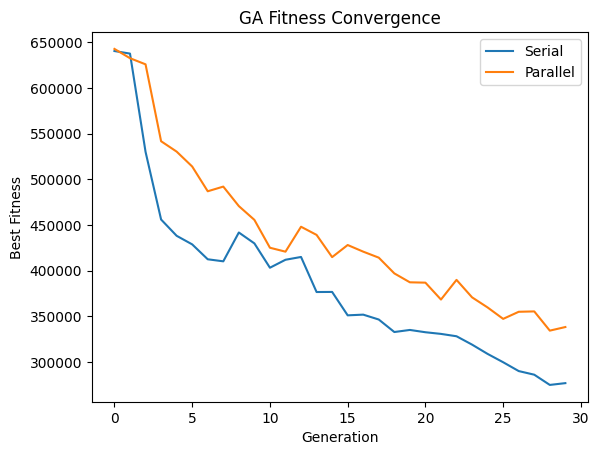

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_serial, label="Serial")
plt.plot(history_parallel, label="Parallel")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.legend()
plt.title("GA Fitness Convergence")
plt.show()

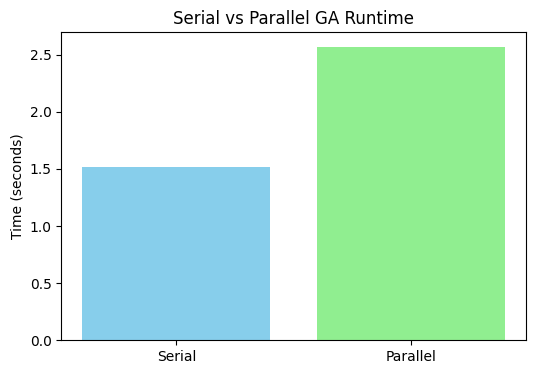

In [ ]:
def plot_runtime(serial_time, parallel_time):
    plt.figure(figsize=(6, 4))
    plt.bar(['Serial', 'Parallel'], [serial_time, parallel_time], color=['skyblue', 'lightgreen'])
    plt.ylabel('Time (seconds)')
    plt.title('Serial vs Parallel GA Runtime')
    plt.show()

plot_runtime(end_serial - start_serial, end_parallel - start_parallel)

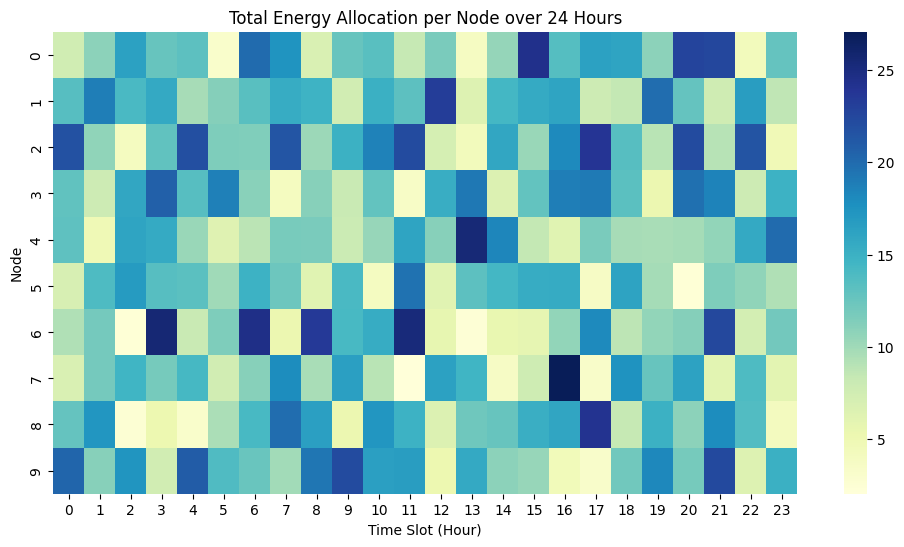

In [ ]:
import seaborn as sns

def plot_allocation_heatmap(best_chrom):
    allocation = best_chrom.reshape(N_NODES, N_SOURCES, T_SLOTS)
    # Sum across sources for each node & time slot
    total_allocation = allocation.sum(axis=1)

    plt.figure(figsize=(12, 6))
    sns.heatmap(total_allocation, cmap='YlGnBu')
    plt.xlabel('Time Slot (Hour)')
    plt.ylabel('Node')
    plt.title('Total Energy Allocation per Node over 24 Hours')
    plt.show()

plot_allocation_heatmap(best_chrom_parallel)

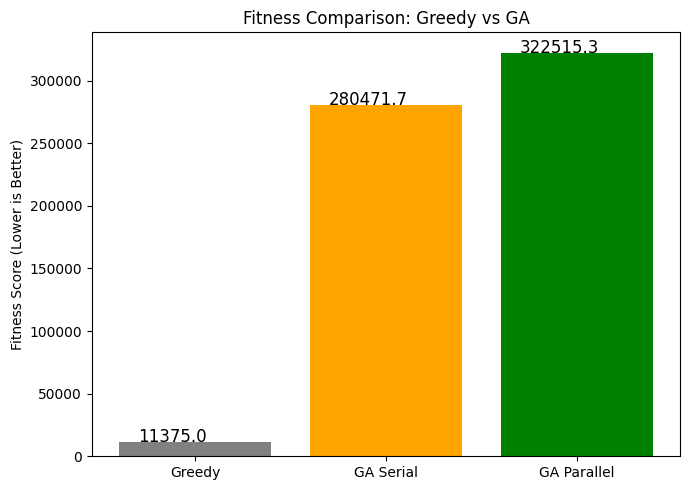

In [ ]:
# Plot Comparison
import matplotlib.pyplot as plt

methods = ['Greedy', 'GA Serial', 'GA Parallel']
fitness_values = [greedy_fit, best_fit_serial, best_fit_parallel]

plt.figure(figsize=(7, 5))
bars = plt.bar(methods, fitness_values, color=['gray', 'orange', 'green'])
plt.title("Fitness Comparison: Greedy vs GA")
plt.ylabel("Fitness Score (Lower is Better)")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.1, yval + 5, f'{yval:.1f}', fontsize=12)

plt.tight_layout()
plt.show()

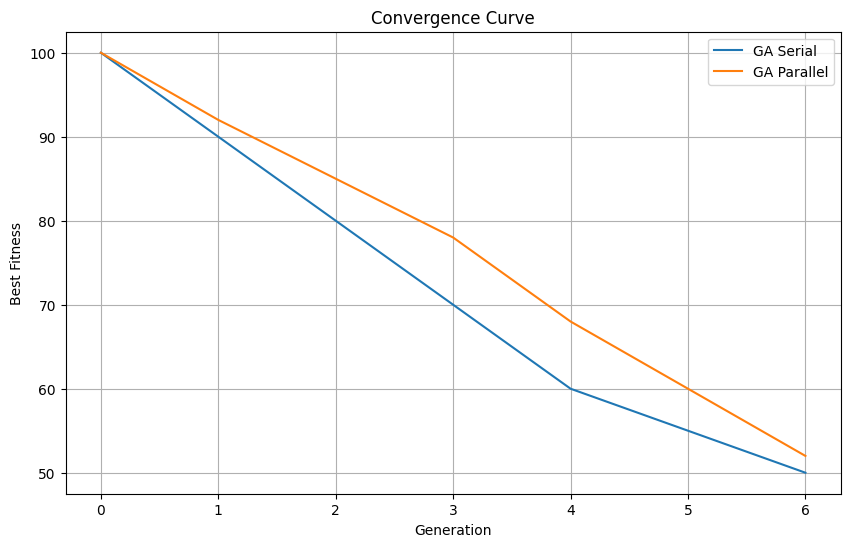

In [ ]:
# Example mock data
history_serial = [100, 90, 80, 70, 60, 55, 50]
history_parallel = [100, 92, 85, 78, 68, 60, 52]

# Now plot
plt.figure(figsize=(10, 6))
plt.plot(history_serial, label='GA Serial')
plt.plot(history_parallel, label='GA Parallel')
plt.title('Convergence Curve')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pip install psutil

In [ ]:
# 1. CPU Usage Monitoring

import psutil
import os

def monitor_cpu_usage(duration=1.0):
    """
    Print CPU usage per core over a duration (seconds).
    """
    print(f"\n[CPU Monitoring - {duration}s sample]")
    usage = psutil.cpu_percent(interval=duration, percpu=True)
    for i, percent in enumerate(usage):
        print(f"Core {i}: {percent:.1f}%")

# Example usage before and after GA
monitor_cpu_usage(1.0)
best_chrom, best_fit, history = run_ga(parallel=True)
monitor_cpu_usage(1.0)


[CPU Monitoring - 1.0s sample]
Core 0: 33.0%
Core 1: 44.0%
Generation 0 Best Fitness: 650017.54
Generation 1 Best Fitness: 610168.36
Generation 2 Best Fitness: 617027.99
Generation 3 Best Fitness: 631059.43
Generation 4 Best Fitness: 542288.65
Generation 5 Best Fitness: 521235.21
Generation 6 Best Fitness: 517775.06
Generation 7 Best Fitness: 533752.77
Generation 8 Best Fitness: 528986.70
Generation 9 Best Fitness: 498988.17
Generation 10 Best Fitness: 471684.03
Generation 11 Best Fitness: 497939.69
Generation 12 Best Fitness: 464796.08
Generation 13 Best Fitness: 476789.30
Generation 14 Best Fitness: 485760.86
Generation 15 Best Fitness: 448314.33
Generation 16 Best Fitness: 438669.55
Generation 17 Best Fitness: 423308.44
Generation 18 Best Fitness: 429529.21
Generation 19 Best Fitness: 420137.73
Generation 20 Best Fitness: 410161.64
Generation 21 Best Fitness: 407092.56
Generation 22 Best Fitness: 414460.13
Generation 23 Best Fitness: 413259.60
Generation 24 Best Fitness: 392563.58


Run 1/5 (Serial)...
Generation 0 Best Fitness: 633029.87
Generation 1 Best Fitness: 650412.96
Generation 2 Best Fitness: 596998.03
Generation 3 Best Fitness: 586435.51
Generation 4 Best Fitness: 569349.54
Generation 5 Best Fitness: 561051.76
Generation 6 Best Fitness: 536403.13
Generation 7 Best Fitness: 566474.36
Generation 8 Best Fitness: 510748.21
Generation 9 Best Fitness: 489720.40
Generation 10 Best Fitness: 484973.27
Generation 11 Best Fitness: 463691.76
Generation 12 Best Fitness: 462795.28
Generation 13 Best Fitness: 461671.97
Generation 14 Best Fitness: 440681.28
Generation 15 Best Fitness: 433119.15
Generation 16 Best Fitness: 430443.87
Generation 17 Best Fitness: 425317.65
Generation 18 Best Fitness: 427012.01
Generation 19 Best Fitness: 419465.24
Generation 20 Best Fitness: 420946.51
Generation 21 Best Fitness: 399848.31
Generation 22 Best Fitness: 379438.60
Generation 23 Best Fitness: 369657.54
Generation 24 Best Fitness: 380507.42
Generation 25 Best Fitness: 371737.01
Ge

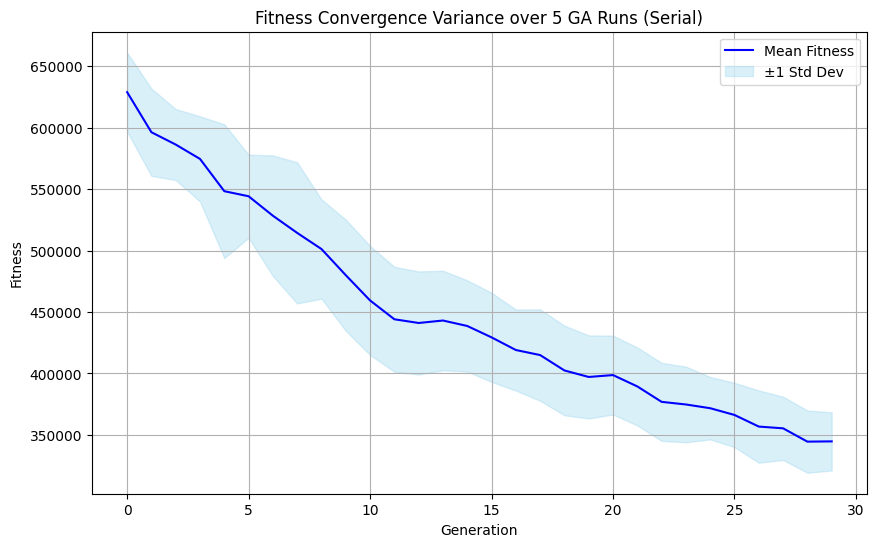


Summary (Serial):
- Mean Best Fitness: 337409.83
- Std Dev of Best Fitness: 20884.10
Run 1/5 (Parallel)...
Generation 0 Best Fitness: 623271.56
Generation 1 Best Fitness: 633456.36
Generation 2 Best Fitness: 616018.93
Generation 3 Best Fitness: 609581.35
Generation 4 Best Fitness: 615134.38
Generation 5 Best Fitness: 579266.38
Generation 6 Best Fitness: 564792.54
Generation 7 Best Fitness: 562659.42
Generation 8 Best Fitness: 555281.39
Generation 9 Best Fitness: 545761.14
Generation 10 Best Fitness: 524721.98
Generation 11 Best Fitness: 528284.62
Generation 12 Best Fitness: 525441.26
Generation 13 Best Fitness: 492359.80
Generation 14 Best Fitness: 488840.63
Generation 15 Best Fitness: 498119.84
Generation 16 Best Fitness: 493666.63
Generation 17 Best Fitness: 478777.36
Generation 18 Best Fitness: 455481.34
Generation 19 Best Fitness: 453393.65
Generation 20 Best Fitness: 452380.53
Generation 21 Best Fitness: 441373.54
Generation 22 Best Fitness: 429218.35
Generation 23 Best Fitness: 

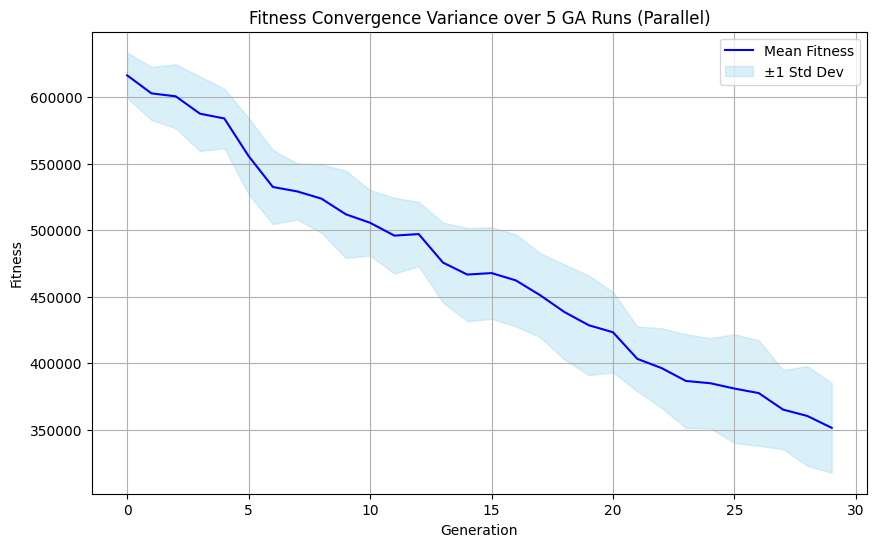


Summary (Parallel):
- Mean Best Fitness: 349951.32
- Std Dev of Best Fitness: 32819.18


In [ ]:
# 2. Fitness Variance Across Multiple Runs(Serial & Parallel)
import numpy as np
import matplotlib.pyplot as plt

def evaluate_fitness_variance(parallel=False, n_runs=5):
    all_histories = []
    best_scores = []

    for i in range(n_runs):
        print(f"Run {i+1}/{n_runs} ({'Parallel' if parallel else 'Serial'})...")
        _, best, hist = run_ga(parallel=parallel)
        best_scores.append(best)
        all_histories.append(hist)

    arr = np.array(all_histories)
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(mean, label='Mean Fitness', color='blue')
    plt.fill_between(range(GENERATIONS), mean - std, mean + std, alpha=0.3, color='skyblue', label='±1 Std Dev')
    plt.title(f"Fitness Convergence Variance over {n_runs} GA Runs ({'Parallel' if parallel else 'Serial'})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nSummary ({'Parallel' if parallel else 'Serial'}):")
    print(f"- Mean Best Fitness: {np.mean(best_scores):.2f}")
    print(f"- Std Dev of Best Fitness: {np.std(best_scores):.2f}")
    return best_scores

# 🔁 Evaluate both modes
fitness_serial_runs = evaluate_fitness_variance(parallel=False, n_runs=5)
fitness_parallel_runs = evaluate_fitness_variance(parallel=True, n_runs=5)